# We use Mordred feature as key ligand properties to build ground truth model so that every validation step can be much faster

In [2]:
import os 
import re
import ast
import glob
import pickle
import collections

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from hyperopt import Trials, fmin, tpe, hp
from hyperopt.early_stop import no_progress_loss
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import shuffle
from xgboost import XGBRegressor

In [4]:
def descriptor_matrix(molecule_index, lookup_table, lookup='SMILES', name=''):
    """Generate a descriptor matrix."""
    
    # New column names
    
    columns = list(lookup_table.columns.values)
    new_columns = []
    for column in columns:
        if name != '':
            new_columns.append(name + '_' + str(column))
        else:
            new_columns.append(column)
    
    # Build descriptor matrix
        
    build = []
    for entry in list(molecule_index):
        match = lookup_table[lookup_table[lookup] == entry]
        if len(match) > 0:
            build.append(list(match.iloc[0]))
        else:
            build.append(np.full(len(columns),np.NaN))
            
    build = pd.DataFrame(data=build, columns=new_columns)
    
    return build

def build_experiment_index(index, index_list, lookup_table_list, lookup_list):
    """Build a descriptor matrix."""

    matrix = descriptor_matrix(index_list[0], 
                               lookup_table_list[0], 
                               lookup=lookup_list[0])
    
    matrix.insert(0, 'entry', list(index))
    
    for i in range(1,len(index_list)):
        new = descriptor_matrix(index_list[i], 
                                lookup_table_list[i], 
                                lookup=lookup_list[i])
        new['entry'] = list(index)
        matrix = matrix.merge(new, on='entry')
    
    return matrix

def load_arylation_data(base='ohe', ligand='ohe', solvent='ohe'):
    """
    Load direct arylation data with different features.
    """
    
    # SMILES index
    index = pd.read_csv('/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/0_Create_Ground_Truth_Model/data/experiment_index.csv')
    
    # Base features
    
    if base == 'dft':    
        base_features = pd.read_csv('/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/0_Create_Ground_Truth_Model/data/base_dft.csv')
    elif base == 'mordred':
        base_features = pd.read_csv('/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/0_Create_Ground_Truth_Model/data/base_mordred.csv')
    elif base == 'ohe':
        base_features = pd.read_csv('/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/0_Create_Ground_Truth_Model/data/base_ohe.csv')
        
    # Ligand features    
          
    if ligand == 'random-dft':
        ligand_features = pd.read_csv('/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/0_Create_Ground_Truth_Model/data/ligand-random_dft.csv')   
    elif ligand == 'boltzmann-dft':
        ligand_features = pd.read_csv('/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/0_Create_Ground_Truth_Model/data/ligand-boltzmann_dft.csv')
    elif ligand == 'mordred':       
        ligand_features = pd.read_csv('/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/0_Create_Ground_Truth_Model/data/ligand_mordred.csv')
    elif ligand == 'ohe':
        ligand_features = pd.read_csv('/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/0_Create_Ground_Truth_Model/data/ligand_ohe.csv')
        
    # Solvent features
    
    if solvent == 'dft':
        solvent_features = pd.read_csv('/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/0_Create_Ground_Truth_Model/data/solvent_dft.csv')
    elif solvent == 'mordred':
        solvent_features = pd.read_csv('/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/0_Create_Ground_Truth_Model/data/solvent_mordred.csv')
    elif solvent == 'ohe':
        solvent_features = pd.read_csv('/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/0_Create_Ground_Truth_Model/data/solvent_ohe.csv')
        
    # Build the descriptor set
    
    index_list = [index['Base_SMILES'],
                  index['Ligand_SMILES'],
                  index['Solvent_SMILES']]
    
    lookup_table_list = [base_features, 
                         ligand_features,
                         solvent_features]
    
    lookup_list = ['base_SMILES', 
                   'ligand_SMILES',
                   'solvent_SMILES']

    experiment_index = build_experiment_index(index['entry'], 
                                              index_list, 
                                              lookup_table_list,
                                              lookup_list)

    experiment_index['concentration'] = index['Concentration']
    experiment_index['temperature'] = index['Temp_C']
    experiment_index['yield'] = index['yield']
    
    return experiment_index

## Read Hyperopt results

In [5]:
directory = 'Model_Create_and_Results1/Direct_ary/0_Create_Ground_Truth_Model/Regression_Model_Analysis'


png_files = glob.glob(os.path.join(directory, 'Parity_plot*.png'))


seed_results = {}


for file in png_files:

    match = re.search(r'Parity_plot_(\w+)_(\w+)_(\d+)', file)
    if match:
        model = match.group(1)
        feature = match.group(2)
        seed = match.group(3)

        key = f'{model}_{feature}'
        print(key)

        if key not in seed_results:
            seed_results[key] = []

        seed_results[key].append(seed)

for key, seeds in seed_results.items():
    print(f'{key}, {len(seeds)} {seeds}')

rfr_mordred
rfr_mordred
rfr_mordred
rfr_mordred
rfr_mordred
rfr_mordred
rfr_mordred
rfr_mordred
rfr_mordred
rfr_mordred
rfr_mordred
rfr_mordred
rfr_mordred, 12 ['379552584', '31382165', '278386563', '748998127', '1014103878', '1011143588', '995809367', '482235279', '36563640', '975779954', '784311177', '188011883']


In [6]:
result_output_file_path = 'Model_Create_and_Results1/Direct_ary/0_Create_Ground_Truth_Model/Regression_Model_Analysis'

hyp_files = glob.glob(os.path.join(result_output_file_path, 'hypoptim_rfr_mordred.sh.o*'))


output_corresponding_seed = {}


for file in hyp_files:

    with open(file, 'r') as f:
        content = f.read()


    match = re.search(r'seed: (\d+)', content)
    if match:
        seed = match.group(1)


        output_corresponding_seed[file] = seed

for file, seed in output_corresponding_seed.items():
    print(f'{file}: {seed}')

/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/0_Create_Ground_Truth_Model/Regression_Model_Analysis/hypoptim_rfr_mordred.sh.o3909985: 379552584
/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/0_Create_Ground_Truth_Model/Regression_Model_Analysis/hypoptim_rfr_mordred.sh.o3909986: 31382165
/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/0_Create_Ground_Truth_Model/Regression_Model_Analysis/hypoptim_rfr_mordred.sh.o3909996: 278386563
/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/0_Create_Ground_Truth_Model/Regression_Model_Analysis/hypoptim_rfr_mordred.sh.o3909988: 748998127
/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/0_Create_Ground_Truth_Model/Regression_Model_Analysis/hypoptim_rfr_mordred.sh.o3909995: 1014103878
/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/0_Create_Ground_Truth_Model/Regression_Model_Analysis/hypoptim_rfr_mordred.sh.o3909987: 1011143588
/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/0_Cre

## Part B-1: Mordred Feature 
Analyzing the hyperparameter optimization results for all files, we compare the differences in fitting between XGBoost and Random Forest. We identify the most important features and determine which features maintain good performance even when reducing the feature set.

In [7]:
reaction_data = load_arylation_data(base='mordred', ligand='mordred', solvent='mordred')

print(reaction_data.dtypes.unique())

for column in reaction_data.select_dtypes(include=['object']).columns:
    print(f"{column}:")

數據集中所有唯一的數據類型：
[dtype('int64') dtype('O') dtype('float64') dtype('bool')]
數據集中所有類型為 'object' 的列：

base_SMILES:
ligand_SMILES:
solvent_SMILES:


In [8]:
reaction_data = reaction_data.select_dtypes(include=['int64', 'float64','bool'])
reaction_data = reaction_data.dropna(axis=1)
reaction_data = reaction_data.drop('entry', axis=1)
reaction_data = shuffle(reaction_data)

X = reaction_data.iloc[:, :-1]
y = reaction_data.iloc[:, -1]
X.columns = X.columns.str.replace('[', '_').str.replace(']', '_').str.replace('<', '_')
print('Shape of data X and y: ', X.shape, y.shape)
X.head()

Shape of data X and y:  (1984, 3593) (1984,)


,base_ABC,base_ABCGG,base_nAcid,base_nBase,base_nAromAtom,base_nAromBond,base_nAtom,base_nHeavyAtom,base_nSpiro,base_nBridgehead,...,solvent_MW,solvent_AMW,solvent_WPath,solvent_WPol,solvent_Zagreb1,solvent_Zagreb2,solvent_mZagreb1,solvent_mZagreb2,concentration,temperature
1645,2.449490,2.449490,1,1,0,0,8,5,0,0,...,87.068414,5.804561,29,4,22.0,21.0,4.222222,1.444444,0.153,120
214,4.876567,5.209852,1,1,0,0,17,8,0,0,...,87.068414,5.804561,29,4,22.0,21.0,4.222222,1.444444,0.100,120
703,4.876567,5.209852,1,1,0,0,17,8,0,0,...,69.057849,5.754821,20,2,14.0,12.0,2.750000,1.500000,0.153,105
884,4.876567,5.209852,1,1,0,0,17,8,0,0,...,87.068414,5.804561,29,4,22.0,21.0,4.222222,1.444444,0.100,90
378,4.876567,5.209852,1,1,0,0,17,8,0,0,...,106.078250,5.893236,62,7,36.0,38.0,3.222222,1.833333,0.057,90


In [9]:
nan_columns = reaction_data.columns[reaction_data.isnull().any()].tolist()
print("Columns with NaN values:", nan_columns)

inf_columns = reaction_data.columns[(reaction_data == np.inf).any()].tolist()
print("Columns with infinity values:", inf_columns)

large_value_columns = reaction_data.columns[(reaction_data > np.finfo(np.float32).max).any()].tolist()
print("Columns with values too large for float32:", large_value_columns)

Columns with NaN values: []
Columns with infinity values: []
Columns with values too large for float32: []


## Part B-2: Mordred Feature 
We're utilizing Mordred features as input for regression with Random Forest Regression (RFR) and XGBoost (XGB). Our goals are to identify the most important features and devise strategies to effectively reduce the feature set for creating predictors tailored to benchmarking tasks.

In [10]:
mordred_rfr_seed_results = seed_results['rfr_mordred']
#mordred_xgb_seed_results = seed_results['xgb_mordred']
mordred_rfr_seed_dict = {}
#mordred_xgb_seed_dict = {}

for seed in mordred_rfr_seed_results:
    for out_file, out_seed in output_corresponding_seed.items():
        if seed == out_seed:
            mordred_rfr_seed_dict[seed] = out_file

"""
for seed in mordred_xgb_seed_results:
    for out_file, out_seed in output_corresponding_seed.items():
        if seed == out_seed:
            mordred_xgb_seed_dict[seed] = out_file
"""

'\nfor seed in mordred_xgb_seed_results:\n    for out_file, out_seed in output_corresponding_seed.items():\n        if seed == out_seed:\n            mordred_xgb_seed_dict[seed] = out_file\n'

## Part B-2: Mordred Feature (RFR)
### Mordred Feature Regression Analysis by using Random Forrest

In [11]:
param_list = []

for seed, file in mordred_rfr_seed_dict.items():
    with open(file, 'r') as f:
        content = f.read()
        match = re.search(r'parameters: (.+)', content)
        if match:
            # print(file)
            # print(f'Seed: {seed}, {match.group(1)}')
            param = ast.literal_eval(match.group(1))
            param = {k: int(v) if k in ['max_depth', 'n_estimators'] else v for k, v in param.items()}
            param = {k: (int(v) if v > 0.5 else v) if k in ['min_samples_leaf'] else v for k, v in param.items()}
            param = {k: (int(v) if v > 1 else v) if k in ['min_samples_split'] else v for k, v in param.items()}            
            param_list.append(param)

In [12]:
top_features_list = []

for i in range(len(mordred_rfr_seed_results)):

    seed = mordred_rfr_seed_results[i]
    params = param_list[i]

    rfr = RandomForestRegressor(**params, random_state=int(seed))
    rfr.fit(X, y)

    importances = rfr.feature_importances_

    features = X.columns

    importances_features = sorted(zip(importances, features), reverse=True)[:50]

    sorted_importances, sorted_features = zip(*importances_features[::-1])

    top_features_list.append(sorted_features)

[[101.83822856 162.99727957 163.00583751 101.83758472 101.83750363
  101.82412772 101.82288694 101.82693207 101.81580122 101.83977791
  101.82138753 101.81879681]
 [101.83822856 162.99727957 163.00583751 101.83758752 101.83659583
  101.82412772 101.82239985 101.82694235 101.81580121 101.83977791
  101.82138753 101.81882019]
 [ 79.92896855 148.20983586 148.19962067  79.90304851  79.90253096
   79.86983362  79.88130122  79.8181155   79.82214108  79.82192951
   79.84369725  79.8351814 ]
 [ 79.91803052 148.20983586 148.19962067  79.89380622  79.88383675
   79.86579435  79.84986566  79.81381867  79.81999911  79.81200048
   79.83125748  79.83512618]
 [  8.5271815   93.91512924  93.8248612    7.98151723   9.702944
    7.84625608   9.58662765   8.15941579   8.1476359    8.17576192
    8.2451965    8.25862466]
 [  8.48000409  93.90833496  93.81941609   8.03465896  10.19843095
    7.95940142  10.10262608   8.10058725   8.16148521   8.21228096
    8.20810126   8.29370596]
 [  8.48000409  93.90833

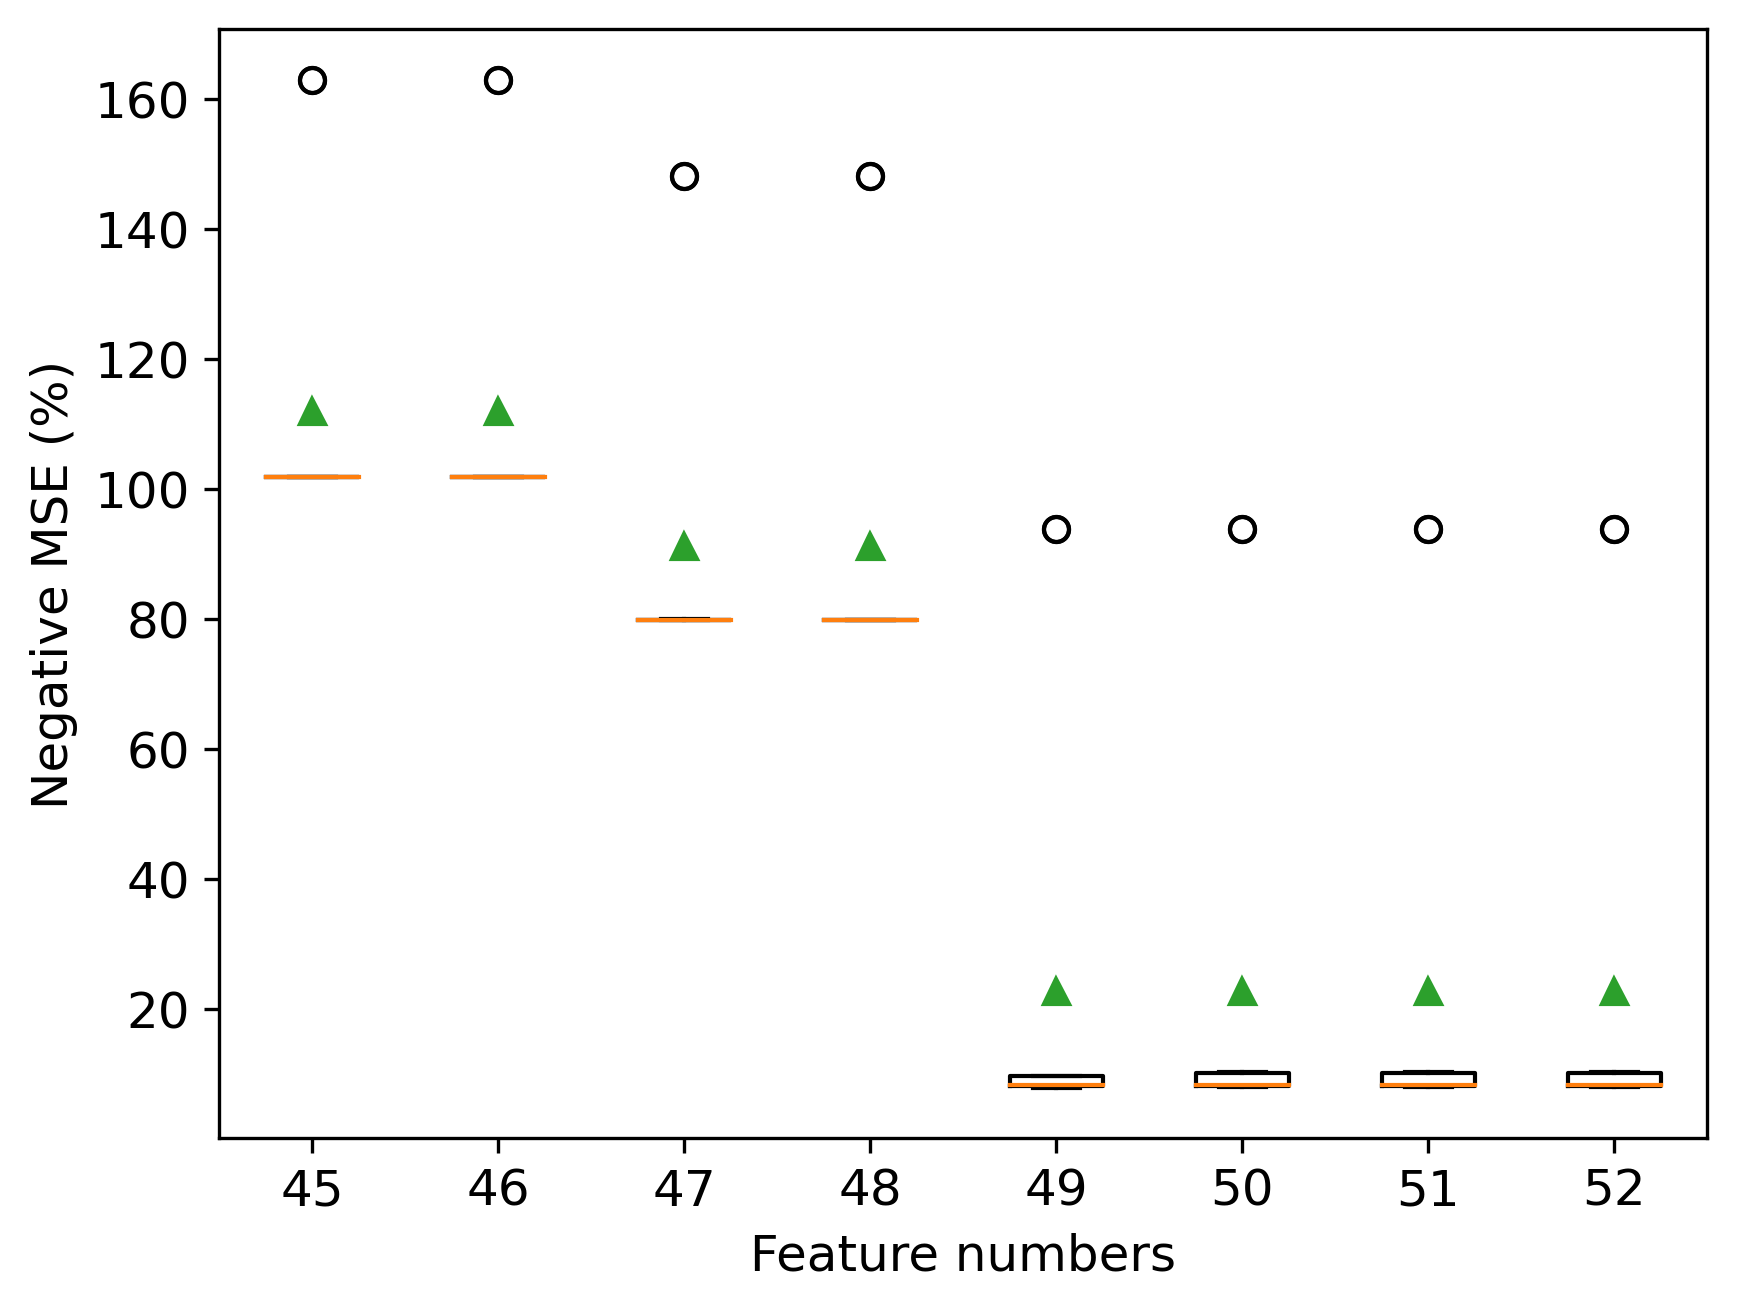

In [28]:
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error

import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

feature_numnbers = [45,46,47,48,49,50,51,52]


r2_scores = np.zeros((len(mordred_rfr_seed_results), len(feature_numnbers)))
mse_scores = np.zeros((len(mordred_rfr_seed_results), len(feature_numnbers)))

for i in range(len(mordred_rfr_seed_results)):

    seed = mordred_rfr_seed_results[i]
    params = param_list[i]

    for j, n_features in enumerate(feature_numnbers):

        top_features = list(top_features_list[i][:n_features])
        X_new = X[top_features]


        rfr = RandomForestRegressor(**params, random_state=int(seed))
        rfr.fit(X_new, y)

 
        y_pred = rfr.predict(X_new)
        mse = mean_squared_error(y, y_pred)
        mse_scores[i, j] = mse

print(mse_scores.T)
print(feature_numnbers)
plt.boxplot(list(mse_scores.T), labels=feature_numnbers, showmeans=True)
font = {'family' : 'sans-serif',
#         'weight' : 'bold',
        'size'   : 12}
plt.rc('font', **font)
plt.rcParams['figure.dpi'] = 300
plt.xlabel('Feature numbers')
# plt.ylim([-0.65,-0.025])
plt.ylabel('MSE (%)')
plt.show()


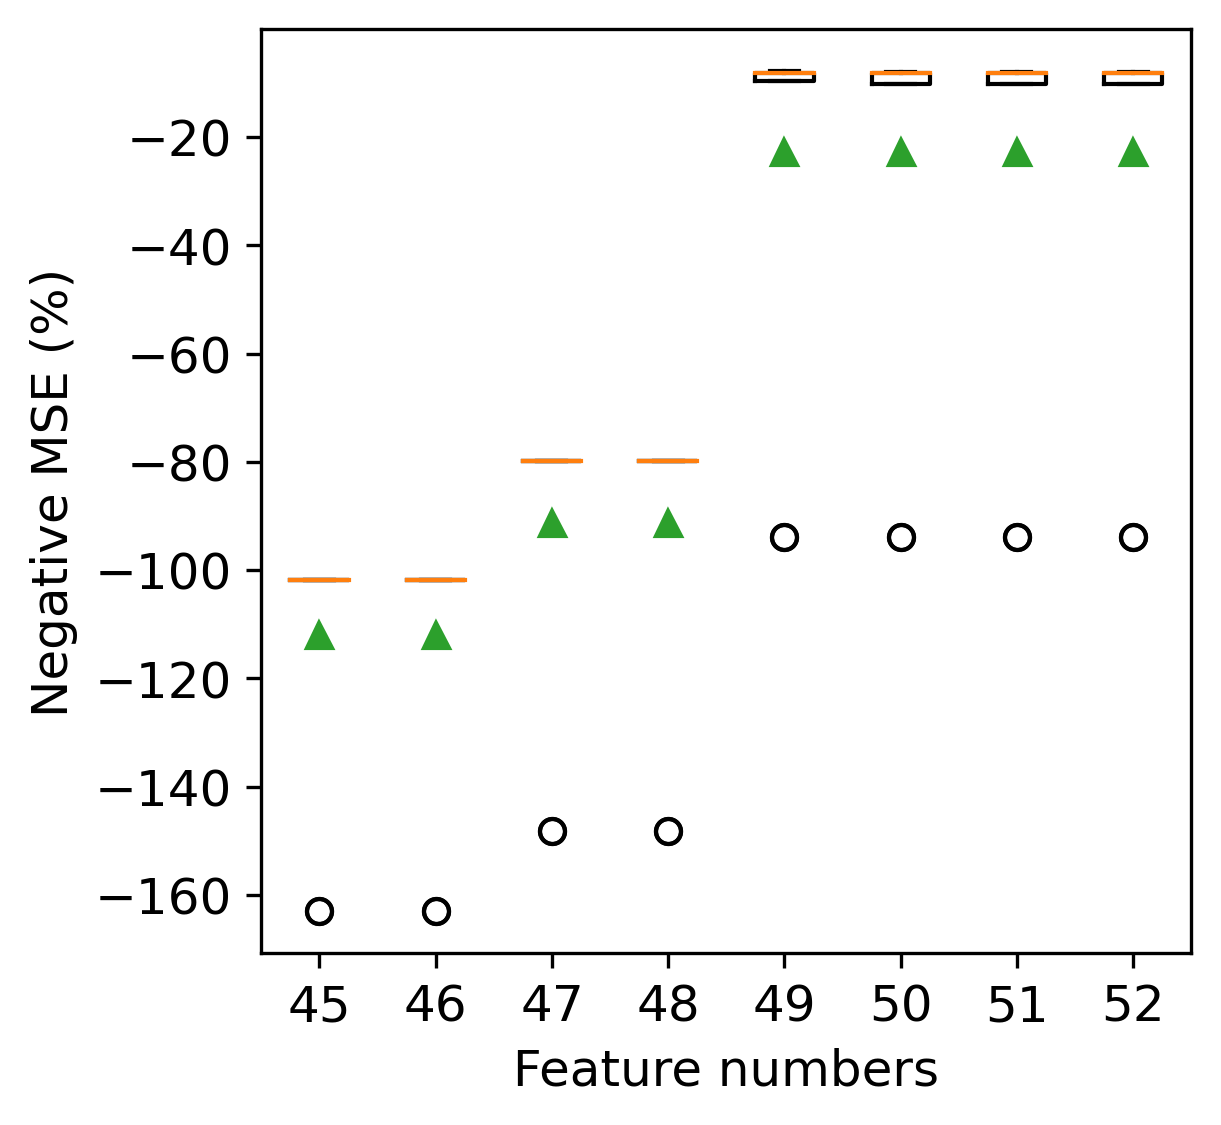

In [30]:
plt.figure(figsize=(4,4))
plt.boxplot(list(-mse_scores.T), labels=feature_numnbers, showmeans=True)
font = {'family' : 'sans-serif',
#         'weight' : 'bold',
        'size'   : 12}
plt.rc('font', **font)
plt.rcParams['figure.dpi'] = 300
plt.xlabel('Feature numbers')
# plt.ylim([-0.65,-0.025])
plt.ylabel('Negative MSE (%)')
plt.show()


ligand_PEOE_VSA10, 12
ligand_AATS4dv, 12
ligand_MATS1p, 12
ligand_AATS6are, 12
ligand_AATS5v, 12
ligand_SlogP_VSA1, 12
ligand_MINsssP, 12
ligand_AATS6se, 12
ligand_MATS1Z, 12
ligand_GATS1are, 12
ligand_MATS6v, 12
ligand_MATS5d, 12
ligand_AATSC5d, 12
ligand_GATS1se, 12
ligand_Xch-7d, 12
concentration, 12
ligand_MATS3i, 12
temperature, 12
ligand_MATS1dv, 12
ligand_AATS5dv, 11
ligand_AATS2are, 11
ligand_MATS1m, 11
ligand_MATS7i, 11
ligand_GATS4dv, 10
ligand_SsssP, 10
ligand_AATS2se, 10
ligand_MAXsssP, 10
ligand_AATS1pe, 10
base_GATS1se, 9
ligand_GATS1pe, 9
ligand_ETA_eta_FL, 9
ligand_ATSC5dv, 9
ligand_AATS5pe, 9
base_GATS2pe, 8
base_GATS3m, 8
ligand_SMR_VSA6, 8
ligand_BCUTc-1l, 7
ligand_AATSC1p, 7
solvent_NsCH3, 6
ligand_AXp-1dv, 6
ligand_BCUTc-1h, 6
ligand_EState_VSA7, 6
solvent_VSA_EState9, 6
ligand_AETA_eta_BR, 6
ligand_AATS5Z, 6
base_GATS3Z, 5
solvent_GATS4se, 5
ligand_ATSC2c, 5
solvent_SdssC, 5
ligand_AATSC1v, 5
ligand_MATS1v, 5
ligand_GATS7v, 5
ligand_SlogP_VSA11, 4
solvent_SsssN, 4

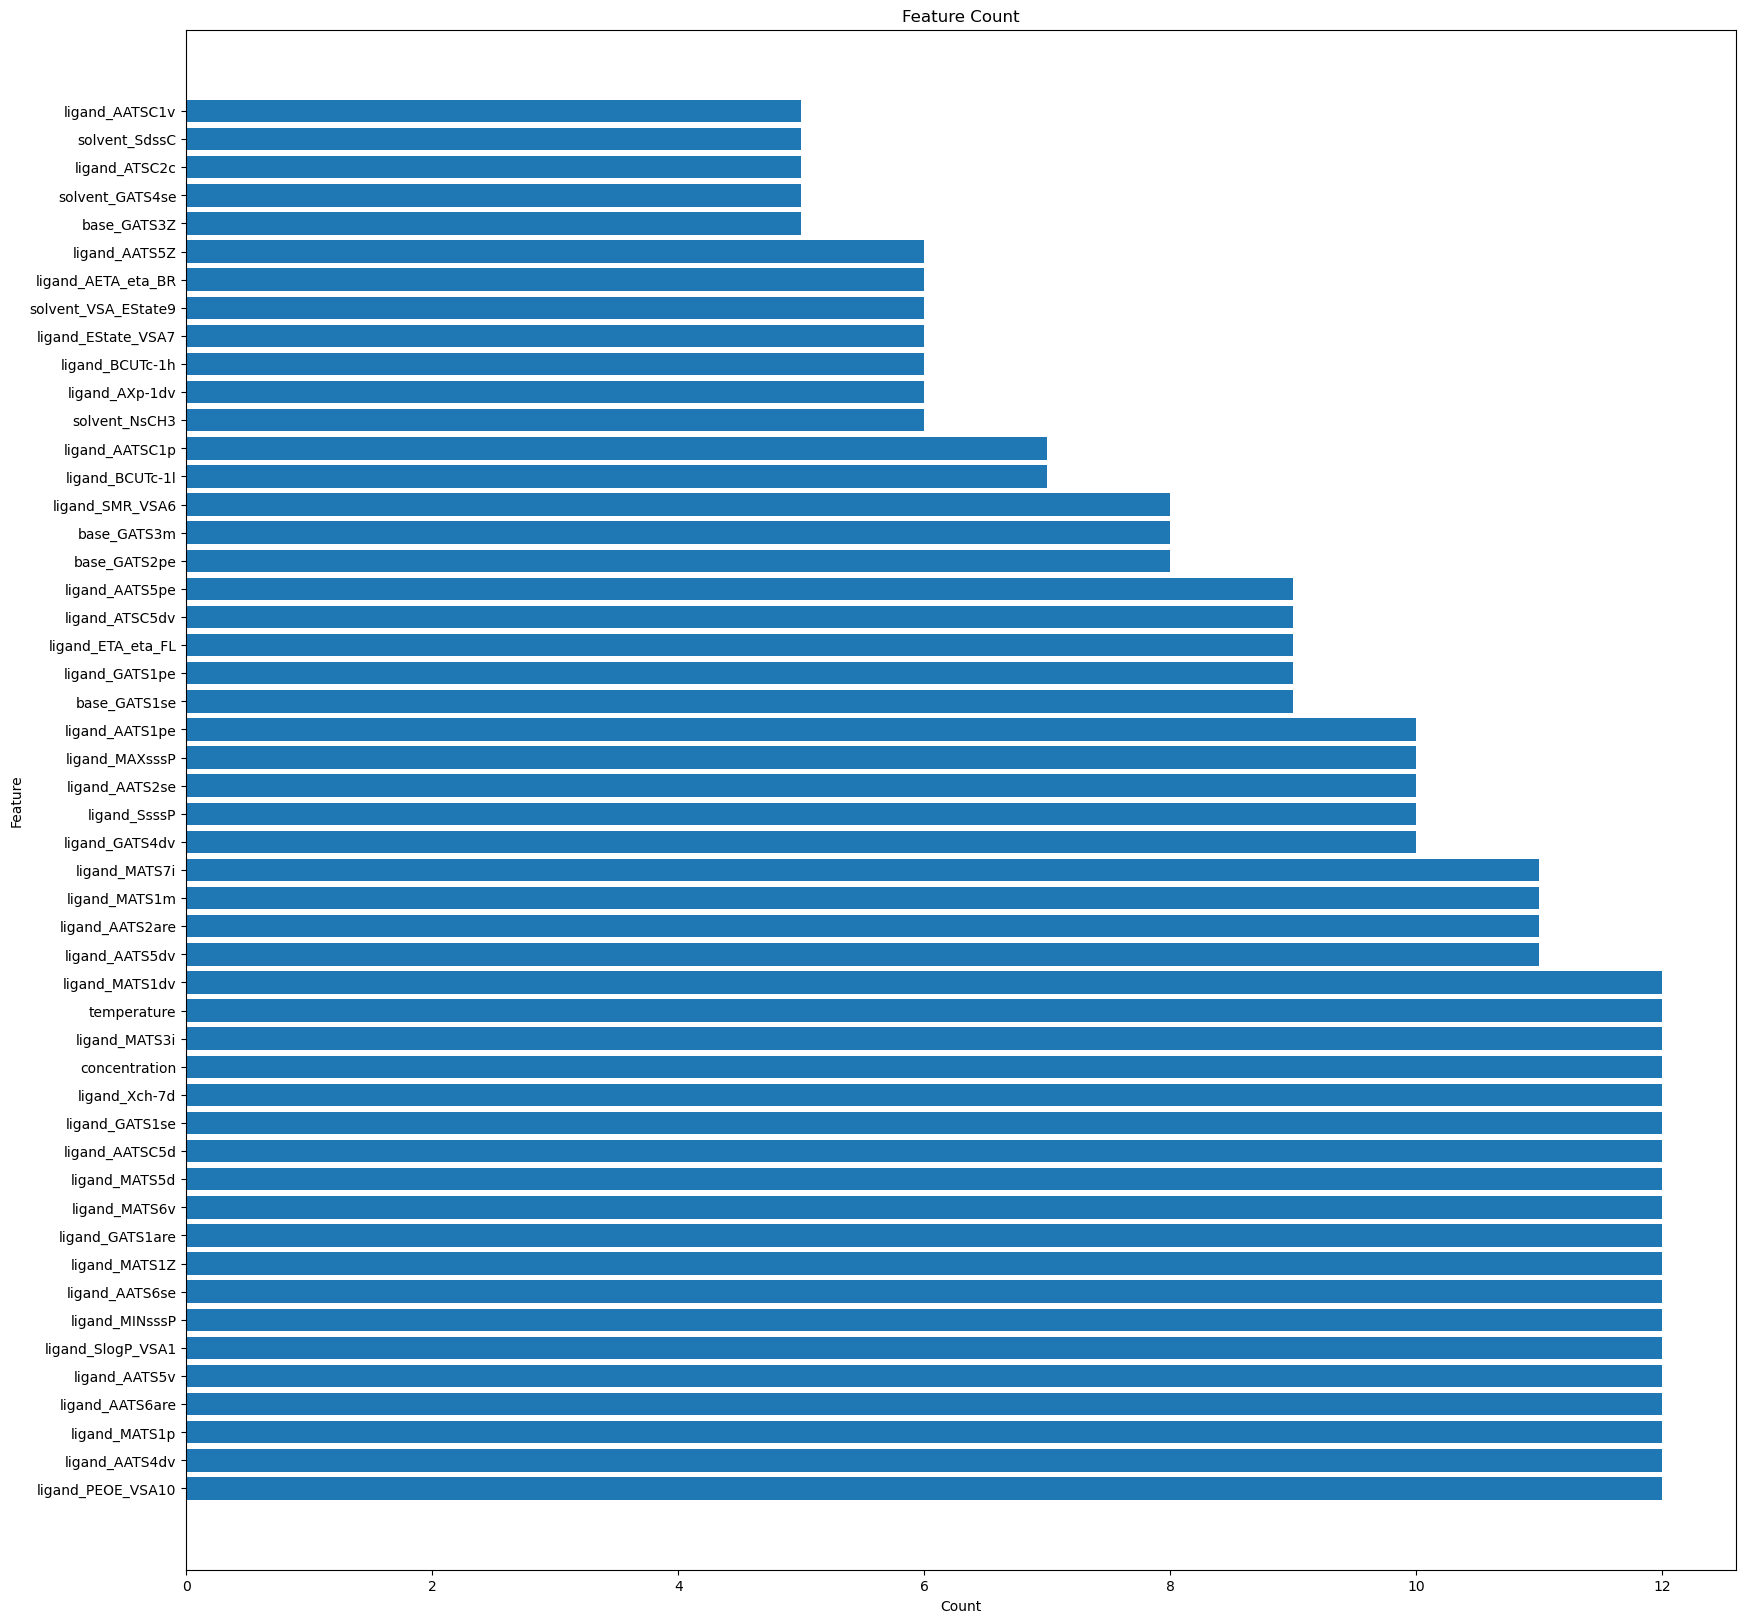

In [20]:
import collections


all_features = [feature for sublist in top_features_list for feature in sublist]

feature_counts = collections.Counter(all_features)

sorted_features = sorted(feature_counts.items(), key=lambda x: x[1], reverse=True)

features, counts = zip(*sorted_features)
for f, c in zip(features, counts):
    print(f'{f}, {c}')

features = features[:50]
counts = counts[:50]

df = pd.DataFrame({'features': features, 'counts': counts})

# Save the DataFrame to a CSV file
df.to_csv('/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/0_Create_Ground_Truth_Model/ground_truth_model/GT_feature_Mordred.csv', index=False)

plt.figure(figsize=(20, 20))
plt.barh(features, counts)
plt.xlabel('Count')
plt.ylabel('Feature')
plt.title('Feature Count')
plt.show()

['ligand_PEOE_VSA10', 'ligand_AATS4dv', 'ligand_MATS1p', 'ligand_AATS6are', 'ligand_AATS5v', 'ligand_SlogP_VSA1', 'ligand_MINsssP', 'ligand_AATS6se', 'ligand_MATS1Z', 'ligand_GATS1are', 'ligand_MATS6v', 'ligand_MATS5d', 'ligand_AATSC5d', 'ligand_GATS1se', 'ligand_Xch-7d', 'concentration', 'ligand_MATS3i', 'temperature', 'ligand_MATS1dv', 'ligand_AATS5dv', 'ligand_AATS2are', 'ligand_MATS1m', 'ligand_MATS7i', 'ligand_GATS4dv', 'ligand_SsssP', 'ligand_AATS2se', 'ligand_MAXsssP', 'ligand_AATS1pe', 'base_GATS1se', 'ligand_GATS1pe', 'ligand_ETA_eta_FL', 'ligand_ATSC5dv', 'ligand_AATS5pe', 'base_GATS2pe', 'base_GATS3m', 'ligand_SMR_VSA6', 'ligand_BCUTc-1l', 'ligand_AATSC1p', 'solvent_NsCH3', 'ligand_AXp-1dv', 'ligand_BCUTc-1h', 'ligand_EState_VSA7', 'solvent_VSA_EState9', 'ligand_AETA_eta_BR', 'ligand_AATS5Z', 'base_GATS3Z', 'solvent_GATS4se', 'ligand_ATSC2c', 'solvent_SdssC', 'ligand_AATSC1v']


Average R^2: 0.8888558837418765
RMSE: 2.877248145222005
Model: RandomForestRegressor
Cross-validation scores: [0.84188398 0.92080367 0.86027037 0.89773615 0.90984701 0.88249441
 0.93423423 0.92414264 0.89139741 0.82574897]
Coefficient of Variation: 0.1626189545230791


<Figure size 450x450 with 0 Axes>

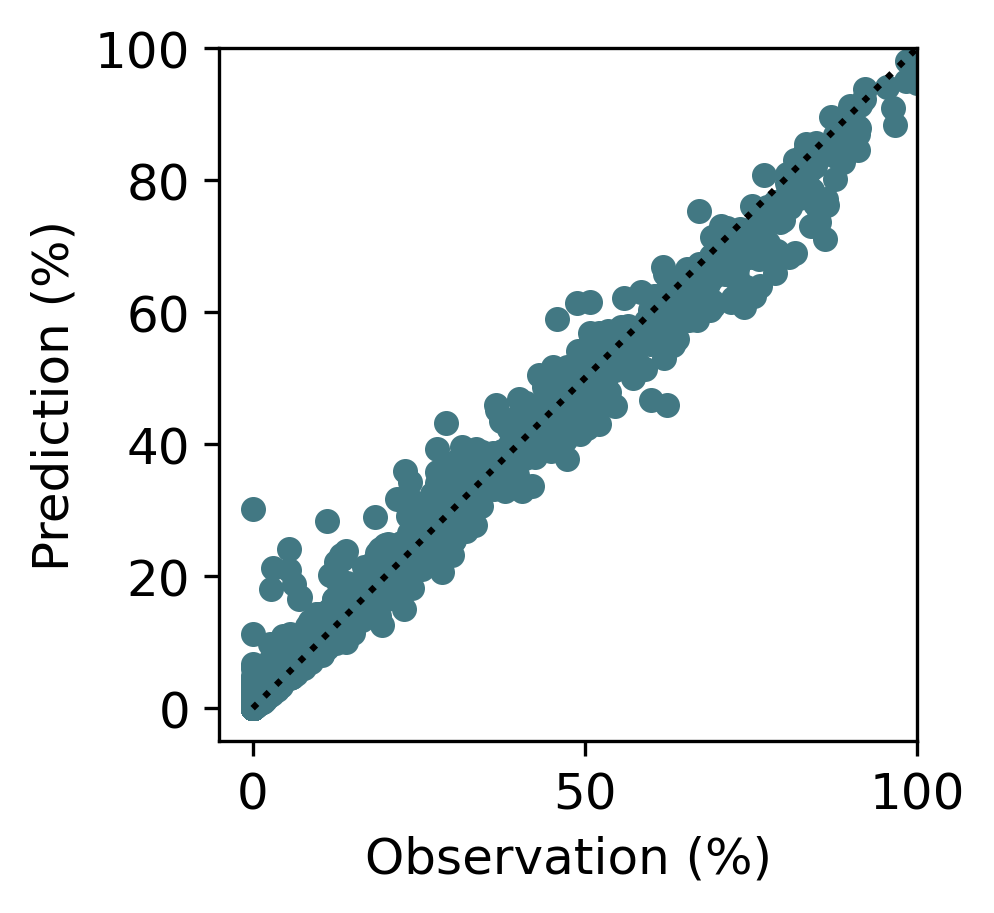

<Figure size 1920x1440 with 0 Axes>

In [12]:
# save the ground truth model
from sklearn.metrics import r2_score
from sklearn import metrics
import pandas as pd
features = pd.read_csv('Model_Create_and_Results1/Direct_ary/0_Create_Ground_Truth_Model/ground_truth_model/GT_feature_Mordred.csv')
featureList = features['features'].tolist()
print(featureList)
X_reduced = X[featureList]

rfr = RandomForestRegressor()

with open('Model_Create_and_Results1/Direct_ary/0_Create_Ground_Truth_Model/ground_truth_model/Ground_Truth_RandomForrest_Mordred.pkl', 'rb') as f:
    rf_regressor = pickle.load(f)


y_pred = rf_regressor.predict(X_reduced)

scores = cross_val_score(rf_regressor, X_reduced, y, cv=10, scoring='r2')


average_r2 = np.mean(scores)
RMSE = np.sqrt(metrics.mean_squared_error(y, y_pred))

print('Average R^2:', average_r2)
print('RMSE:', RMSE)

mean = np.mean(scores)
std = np.std(scores)

print(f'Model: RandomForestRegressor\nCross-validation scores: {scores}')
y_pred = rf_regressor.predict(X_reduced)
r2 = r2_score(y, y_pred)
rmse = np.sqrt(metrics.mean_squared_error(y, y_pred))
mean = np.mean(y)
print('Coefficient of Variation:', rmse/ mean)
fontsize = 12
plt.figure(figsize=(1.5,1.5))
plt.rcParams['figure.dpi'] = 300
plt.figure(figsize=(3,3))
font = {'family' : 'sans-serif',
        #'weight' : 'bold',
        'size'   : 12}
plt.rc('font', **font)
a = plt.scatter(y, y_pred, s=25,c='#427883')
plt.plot([0, 100], [0, 100], 'k:', lw=1.5)
plt.xlim(right=100)
plt.ylim(top=100)
plt.xlabel('Observation (%)', fontsize=fontsize)
plt.ylabel('Prediction (%)', fontsize=fontsize)
#plt.tick_params(direction='out')

#plt.tight_layout()
plt.show()

plt.savefig(f'Model_Create_and_Results1/Direct_ary/0_Create_Ground_Truth_Model/Regression_Model_Analysis/Parity_plot_RandomForestRegressor_50_features_paper.png')

# 保存模型
#with open('/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/0_Create_Ground_Truth_Model/ground_truth_model/Ground_Truth_RandomForrest_Mordred.pkl', 'wb') as f:
    #pickle.dump(rfr, f)

In [24]:
# Count leaves
with open('/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/0_Create_Ground_Truth_Model/ground_truth_model/Ground_Truth_RandomForrest_Mordred.pkl', 'rb') as f:
    estimator = pickle.load(f)
leaf_counts = [Estimator.get_n_leaves() for Estimator in estimator]
mean_leaves = np.mean(leaf_counts)
print(mean_leaves)

987.93


In [10]:
#SHAP Analysis
import shap
import pandas as pd

features = pd.read_csv('/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/0_Create_Ground_Truth_Model/ground_truth_model/GT_feature_Mordred.csv')
featureList = features['features'].tolist()

# Use shap to explain our rf_regressor
with open('/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/0_Create_Ground_Truth_Model/ground_truth_model/Ground_Truth_RandomForrest_Mordred.pkl', 'rb') as f:
    rf_regressor = pickle.load(f)
explainerRF = shap.TreeExplainer(rf_regressor, check_additivity=False)

X_all_pre_noCorr_RFE = X[featureList[:10]]
# Get standardized X Dataframe
X_stand_df = X_all_pre_noCorr_RFE
shap_values_RF_test = explainerRF.shap_values(X_all_pre_noCorr_RFE)

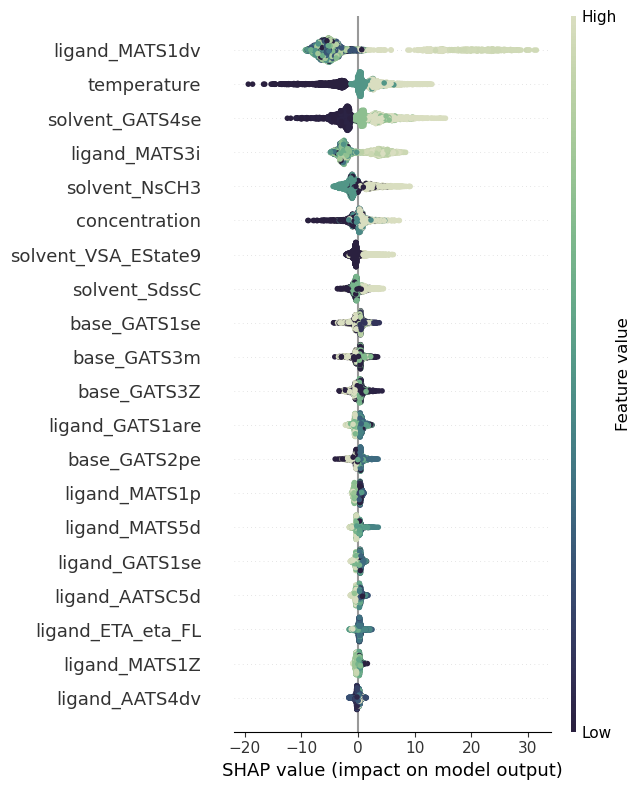

In [11]:
# Plot SHAP figure
import seaborn as sns
plt.figure()
shap.summary_plot(shap_values_RF_test, X_stand_df,plot_type = "dot",
                            #color=plt.get_cmap("plasma"),
                           show = False)
# plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams.update({'font.size': 60})
plt.rcParams['figure.dpi'] = 300

# Change the colormap of the artists, UNCOMMENT FOR DEFAULT COLORMAP
# my_cmap = plt.get_cmap('viridis')
cmap = sns.cubehelix_palette(start=.45, rot=-.75, reverse=True, as_cmap=True)
for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(cmap)

# plt.show()
plt.tight_layout()

# UNCOMMENT TO SAVE A FIGURE
# plt.savefig('20211007_rf_nonstand_shap_264datapoints_median_4.png', dpi = 1200)